In [4]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from netCDF4 import Dataset
import os
from os import path
import pandas as pd

In [5]:
glider_data = './datasets/unit_049_2006_07_delayed/unit_049_delayed_trajectory.nc' 
gl_raw = xr.open_dataset(glider_data,group='glider_record',decode_times=False)
gl = xr.open_dataset(glider_data,decode_times=False)

bathy_source='./datasets/gebco_2023_bathymetry/gebco_2023_n65.0_s40.0_w-75.0_e-45.0.nc'
bathy_data = xr.open_dataset(bathy_source)
# Subset the bathymetry data to the region of interest
lon_min, lon_max = np.min(gl.lon_qc)-1/12, np.max(gl.lon_qc)+1/12
lat_min, lat_max = np.min(gl.lat_qc)-1/12, np.max(gl.lat_qc)+1/12

bathy_subset = bathy_data.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))

#print(bathy_data)

In [6]:

from scipy.interpolate import interp1d
u = gl.u.to_numpy()
v = gl.v.to_numpy()
nans, x = np.isnan(u), lambda z: z.nonzero()[0]
u[nans] = np.interp(x(nans), x(~nans), u[~nans])
v[nans] = np.interp(x(nans), x(~nans), v[~nans])

Text(0, 0.5, 'Latitude [degN]')

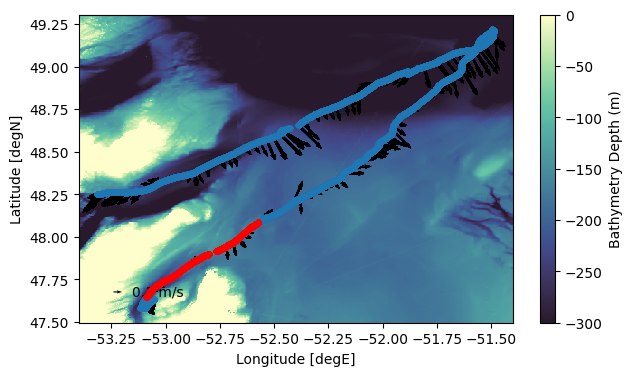

In [76]:
# Select index of data 
#dive = 550

indx = (gl.profile_index >1400) & (gl.profile_index <1600)

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo

fig1, ax1 = plt.subplots(1, 1, figsize=(7, 4))
contour = ax1.pcolor(bathy_subset['lon'],bathy_subset['lat'],bathy_subset['elevation'],cmap=cmo.deep_r,vmin=-300,vmax=0)
ax1.plot(gl.lon_qc, gl.lat_qc, '.')
ax1.plot(gl.lon_qc[indx], gl.lat_qc[indx], '.r')

nan_mask = ~np.isnan(gl['profile_lon'])
quiver=ax1.quiver(gl.lon_qc[nan_mask],gl.lat_qc[nan_mask],u[nan_mask],v[nan_mask],scale=5)

# Add colorbar for bathymetry
cbar = plt.colorbar(contour, ax=ax1, orientation='vertical', pad=0.05)
cbar.set_label('Bathymetry Depth (m)')

quiver_key = ax1.quiverkey(quiver, 0.1, 0.1, 0.1, '0.1 m/s', labelpos='E', coordinates='axes')


# Set labels and title
ax1.set_xlabel('Longitude [degE]')
ax1.set_ylabel('Latitude [degN]')


Text(0, 0.5, 'P [dbar]')

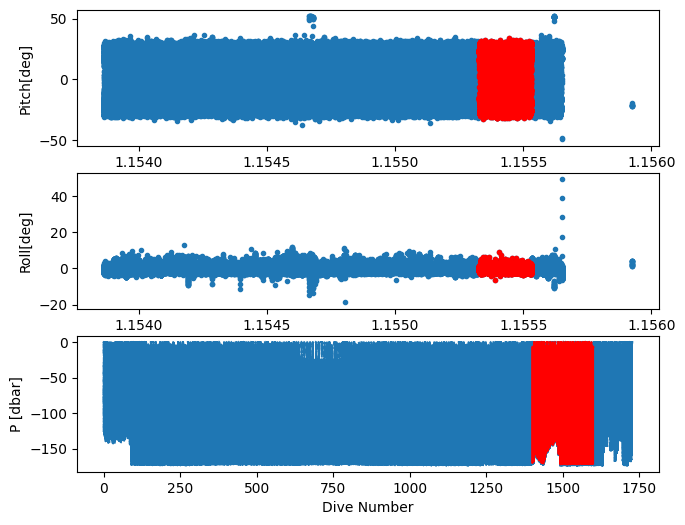

In [78]:
fig, ax = plt.subplots(3,1, figsize=(7.5, 6))
ax[0].plot(gl.time,gl_raw['m_pitch'],'.')
ax[0].plot(gl.time[indx],gl_raw['m_pitch'][indx],'.r')
ax[0].set_ylabel('Pitch[deg]')
ax[0].set_xlabel('Time Unix[s]')

ax[1].plot(gl.time,gl_raw['m_roll'],'.')
ax[1].plot(gl.time[indx],gl_raw['m_roll'][indx],'.r')
ax[1].set_ylabel('Roll[deg]')
ax[1].set_xlabel('Time Unix[s]')

ax[2].plot(gl.profile_index, -gl.pressure)
ax[2].plot(gl.profile_index[indx], -gl.depth[indx], 'r')
ax[2].set_xlabel('Dive Number')
ax[2].set_ylabel('P [dbar]')

In [79]:
# Visualize Roll Rate
from scipy.interpolate import interp1d

# Extract m_roll and time
m_roll = gl_raw['m_roll'].to_numpy()
time = gl_raw['time'].to_numpy()

# Fill NaNs using interpolation
nans, x = np.isnan(m_roll), lambda z: z.nonzero()[0]
m_roll[nans] = np.interp(x(nans), x(~nans), m_roll[~nans])

# Create an evenly spaced time vector with 5-second intervals
time_even = np.arange(time.min(), time.max(), 10)

# Interpolate m_roll to the evenly spaced time vector
interp_even = interp1d(time, m_roll, kind='linear')
m_roll_even = interp_even(time_even)

# Calculate the derivative with respect to the evenly spaced time vector
dt = np.diff(time_even)
dm_roll = np.diff(m_roll_even)
roll_rate_even = dm_roll / dt

# Interpolate the rate of change back to the original timestamps
roll_rate = interp1d(time_even[:-1], roll_rate_even, kind='linear', fill_value="extrapolate")
roll_rate = roll_rate(time)


Text(0.5, 1.0, 'Glider Roll Rate vs Depth and Profile Number')

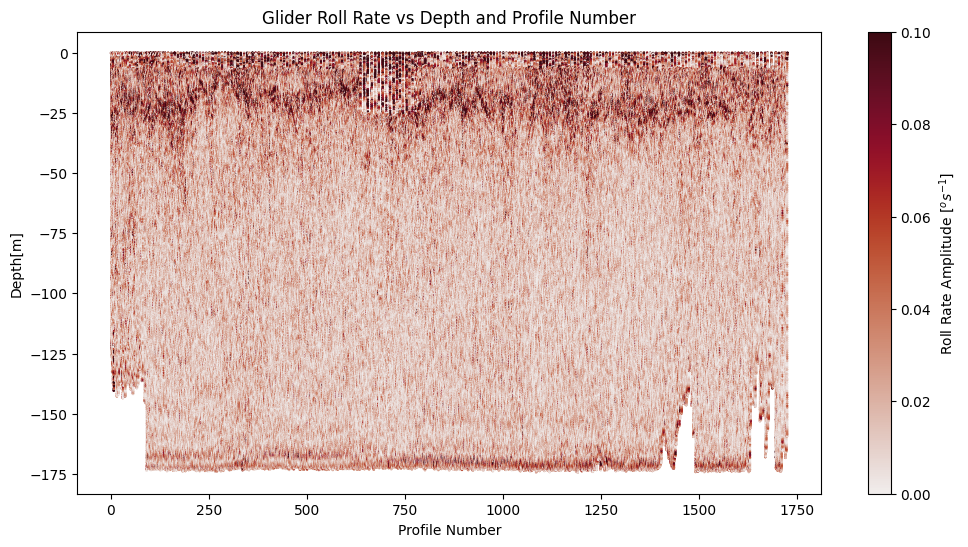

In [12]:
# Plot the results

fig2, ax2 = plt.subplots(1, 1, figsize=(12, 6))
sct = ax2.scatter(gl.profile_index, -gl_raw['m_depth'], c=np.abs(roll_rate), cmap=cmo.amp, s=0.5)  # Set smaller size for scatter dots
sct.set_clim(0, 0.1)

# Set custom color axis limits
cbar = plt.colorbar(sct, ax=ax2)
cbar.set_label('Roll Rate Amplitude [$^o s^{-1}$]')

# Set labels and title
ax2.set_xlabel('Profile Number')
ax2.set_ylabel('Depth[m]')
ax2.set_title('Glider Roll Rate vs Depth and Profile Number')

# No low power used on old missions shows better application of glider roll rate

In [8]:
print(len(roll_rate),len(gl_raw['time']))

2779012 2779012


In [80]:
## Create data subset
# Extract the common time coordinate    
time = gl_raw['sci_m_present_time'][indx]
#time = gl_raw['time'][indx]
# Create data subset ensuring all variables share the same time coordinate
ds_subset = xr.Dataset({
    'time': time,
    'pressure': (['time'], gl_raw['sci_water_pressure'][indx].values),
    'lon': (['time'], gl['lon_qc'][indx].values),
    'lat': (['time'], gl['lat_qc'][indx].values),
    'pitch': (['time'],gl_raw['m_pitch'][indx].values),
    'buoyancy':(['time'], gl_raw['m_ballast_pumped'][indx].values),
    'roll': (['time'],gl_raw['m_roll'][indx].values),
    'dive_nr':(['time'],gl['profile_index'][indx].values),
    'density':(['time'],gl['density'][indx].values),
    'roll_rate':(['time'],roll_rate[indx])
})
df = ds_subset.to_dataframe().reset_index()
df = df.interpolate(method='linear') # Fill NaN gaps with linear interpolation
df = df.fillna(method='bfill').fillna(method='ffill') # Ensure there are no remaining NaNs
df = df.drop_duplicates(subset='time')  # Remove duplicate time values

#import gsw
#df['salinity'] = gsw.conversions.SP_from_C(df['conductivity'] * 10, df['temperature'], df['pressure'])
#df['salinity_SA'] = gsw.conversions.SA_from_SP(df['salinity'], df['pressure'], df['lon'], df['lat'])
#df['temperature_CT'] = gsw.conversions.CT_from_t(df['salinity_SA'], df['temperature'], df['pressure'])
#df['density'] = gsw.density.rho(df['salinity_SA'], df['temperature_CT'], df['pressure'])


/var/folders/fm/r3t8tdqn0hl_605bqdmlc2m80000gn/T/ipykernel_91923/2879829341.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill').fillna(method='ffill') # Ensure there are no remaining NaNs


In [12]:
#plt.plot(df['time'],-df['pressure'])

(-0.5, 0.5)

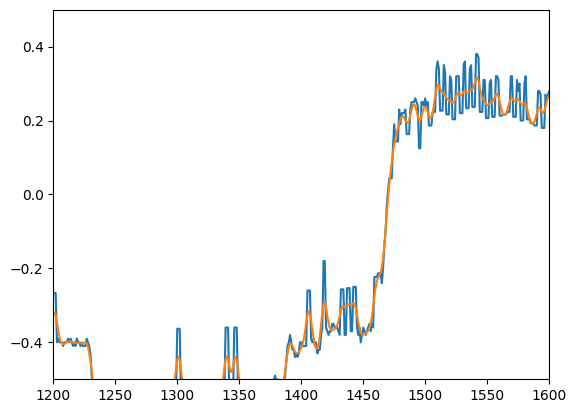

In [85]:
#window_size = 10  # You can adjust this window size to get the desired smoothing effect
#df['pressure_smoothed'] = df['pressure'].rolling(window=window_size).mean()

#from scipy.signal import savgol_filter
#window_length = 11  # Window length must be a positive odd integer
#polyorder = 3 # Polynomial order must be less than window_length
#df['pressure_smoothed'] = savgol_filter(df['pressure'], window_length, polyorder)

from scipy.signal import butter, filtfilt

# Apply a Butterworth filter to the pressure data
def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

# Define filter parameters
cutoff_frequency = 1 / 20 # 10-second cutoff frequency in Hz (1/10 Hz)
sampling_frequency = 1 / np.median(np.diff(df['time']))  # Sampling frequency of the data in Hz
order = 2  # Order of the filter

# Apply the filter
df['pressure_smoothed'] = butter_lowpass_filter(df['pressure'], cutoff_frequency, sampling_frequency, order)


plt.plot(df.index,np.concatenate(([0], np.diff(df.pressure))))
plt.plot(df.index,np.concatenate(([0], np.diff(df.pressure_smoothed))))
plt.xlim(1200,1600)
plt.ylim(-0.5,0.5)

1026.7125847535697 0
Series([], Name: pressure, dtype: float64)


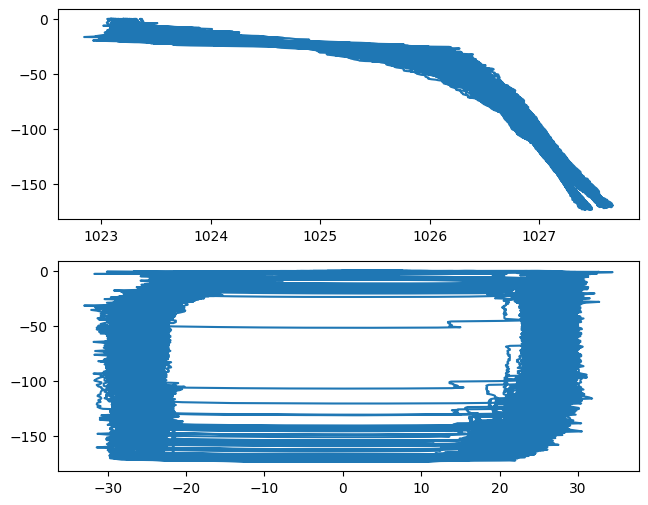

In [86]:
data = {
    'time': df.index.to_numpy()-np.min(df.index.to_numpy()),
    'pressure': df['pressure_smoothed'].to_numpy()/10,
    'pitch': np.deg2rad(df['pitch'].to_numpy()),
    'pitch_deg': df['pitch'].to_numpy(),
    'buoyancy_change': df['buoyancy'].to_numpy(),
    'density': df['density'].to_numpy(),
    'dive_nr': df['dive_nr'].to_numpy(),
    'roll': df['roll'].to_numpy(),
    'roll_rate': df['roll_rate'].to_numpy()
}

fig, ax = plt.subplots(2,1, figsize=(7.5, 6))
ax[0].plot(data['density'],-data['pressure']*10)
ax[1].plot(data['pitch_deg'],-data['pressure']*10)
print(np.mean(data['density'][data['pressure']*10>20]),np.min(data['time']))

print(df['pressure'][np.isnan(df['pressure'])])

In [87]:
import gliderflight
rho0=1026.5
gm = 52
GM = gliderflight.SteadyStateCalibrate(rho0)
GM.define(mg=gm,Vg=gm/rho0,Cd0=0.098) # You want to either supply ah=3.8,Cd1=10.492 and or Cd0 but not both.
#data['dhdt']=GM.compute_dhdt(data['time'],data['pressure'])
GM.set_input_data(pitch=data['pitch'],buoyancy_change=data['buoyancy_change'],time=data['time'],
                  pressure=data['pressure'],density=data['density'])
GM.OR(data['pressure']*10<70)
GM.OR(data['pressure']*10>125)
calibration_result = GM.calibrate('Cd0','Vg',constraints="dhdt")# Optimize for Total Drag and volume. 
print(GM.get_settings())
print(GM.RHO0)
print(calibration_result)
#plt.plot(data['dhdt'])

{'Cd0': 0.028346144086808387, 'Cd1': 10.492635453419751, 'S': 0.1, 'eOsborne': 0.8, 'AR': 7, 'Omega': 0.7504915783575616, 'mg': 52, 'epsilon': 5e-10, 'Vg': 0.05076903163341119, 'Cd1_hull': 9.7, 'aw': 3.7342698372847303, 'ah': 3.8}
1026.5
{'Cd0': 0.02834352917350361, 'Vg': 0.05076900334023147}


Text(0, 0.5, 'Depth[m]')

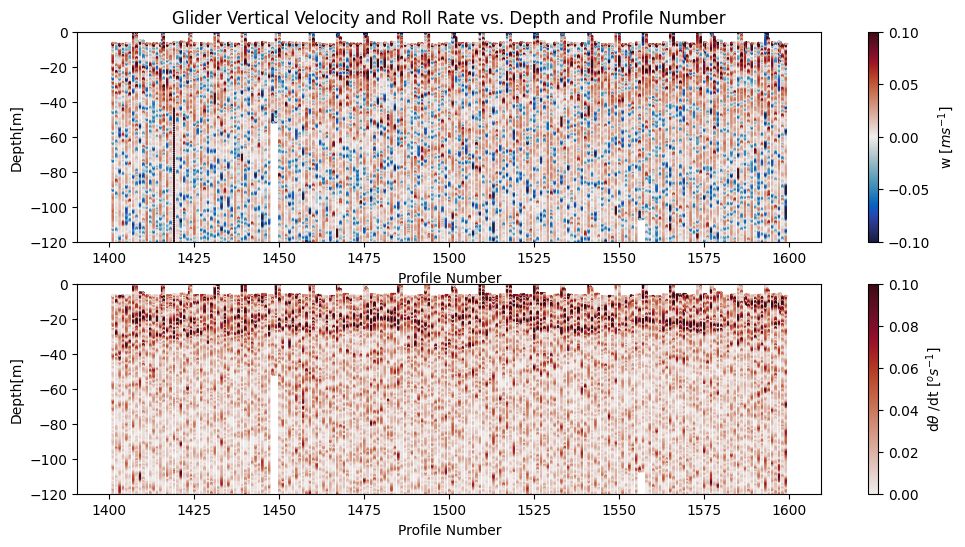

In [89]:
# Plot the results

fig3, ax3 = plt.subplots(2, 1, figsize=(12, 6))
sct = ax3[0].scatter(data['dive_nr'], -data['pressure']*10, c=GM.w, cmap=cmo.balance, s=0.5)  # Set smaller size for scatter dots
sct.set_clim(-0.1, 0.1)

# Set custom color axis limits
cbar = plt.colorbar(sct, ax=ax3[0])
cbar.set_label('w [$m s^{-1}$]')
ax3[0].set_ylim(-120,0)

# Set labels and title
ax3[0].set_xlabel('Profile Number')
ax3[0].set_ylabel('Depth[m]')
ax3[0].set_title('Glider Vertical Velocity and Roll Rate vs. Depth and Profile Number')


sct2 = ax3[1].scatter(data['dive_nr'], -data['pressure']*10, c=np.abs(data['roll_rate']), cmap=cmo.amp, s=0.5)  # Set smaller size for scatter dots
sct2.set_clim(0, 0.1)

# Set custom color axis limits
cbar2 = plt.colorbar(sct2, ax=ax3[1])
cbar2.set_label(r'd$\theta$ /dt [$^o s^{-1}$]')
ax3[1].set_ylim(-120,0)

# Set labels and title
ax3[1].set_xlabel('Profile Number')
ax3[1].set_ylabel('Depth[m]')

In [13]:
# Run Dynamic Model DONT USE 2024-06-25 L. Merkelbach Discussion
#dm = gliderflight.DynamicGliderModel(rho0=1025, k1=0.2, k2=0.98, dt=2)
#dm.define(Vg=74/1025, ah=3.8, mg=74, Cd0=0.098,Cd1=12)
#pressure, buoyancy_change = dm.convert_pressure_Vbp_to_SI(data['pressure'],
#                                                          data['buoyancy_change'])
#data['FB'], data['Fg'] = dm.compute_FB_and_Fg(pressure,data['density'], buoyancy_change)
#dm.get_settings()
#alpha, U = dm.solve(data)

#dm.compute_lift_and_drag(FB)

1.0


Text(0, 0.5, 'Pitch[$^o$]')

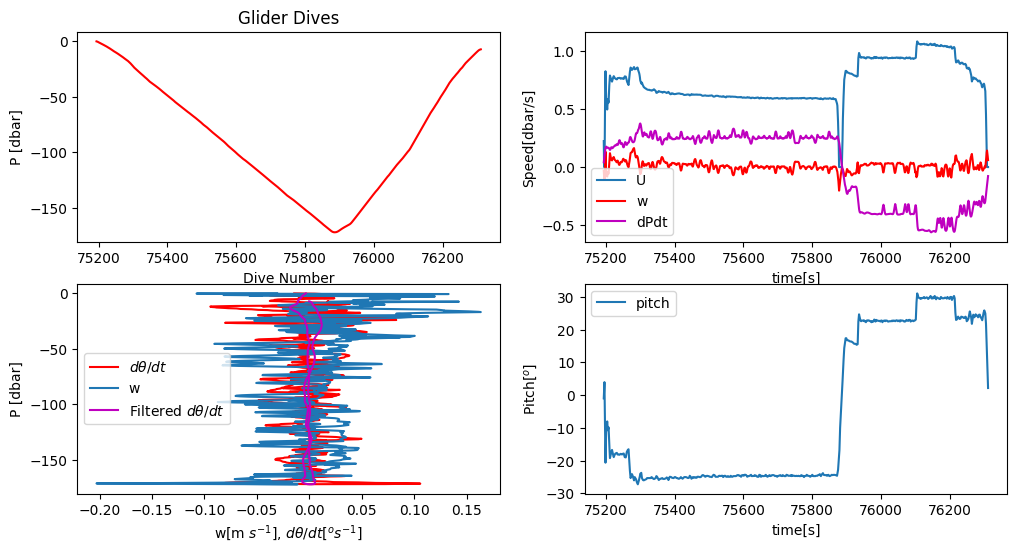

In [98]:
# gm.t # time
# gm.U # incident velocity
# gm.alpha # angle of attack
# gm.ug    # horizontal speed
# gm.wg    # vertical speed
# gm.w     # vertical water velocity

dPdt = np.concatenate(([0], np.diff(data['pressure']*10)))
#roll_rate = np.concatenate(([0], np.diff(data['roll'])))

fig, ax = plt.subplots(2,2, figsize=(12, 6))
dive = 1550
idx =  ((data['dive_nr'] == dive) | (data['dive_nr'] == dive+1)) # & (data['pressure']*10>7) & (data['pressure']*10<230) 


# Plot dive record
#ax[0,0].plot(data['time'],-data['pressure']*10)
ax[0,0].plot(data['time'][idx],-data['pressure'][idx]*10,'r')
ax[0,0].set_title('Glider Dives')
ax[0,0].set_xlabel('Dive Number')
ax[0,0].set_ylabel('P [dbar]')


# Plot Vertical velocity and selected dive
ax[0,1].plot(data['time'][idx],GM.U[idx],label='U')
ax[0,1].plot(data['time'][idx],GM.w[idx],'r',label='w')
ax[0,1].plot(data['time'][idx],dPdt[idx],'m',label='dPdt')
ax[0,1].set_xlabel('time[s]')
ax[0,1].set_ylabel('Speed[dbar/s]')
ax[0,1].legend()


# Plot Roll Rate and Vertical Velocity as a function of pressure
cutoff_frequency = 1 / 20 # 10-second cutoff frequency in Hz (1/10 Hz)
sampling_frequency = 1 / np.median(np.diff(data['time']))  # Sampling frequency of the data in Hz
print(sampling_frequency)
order = 1  # Order of the filter

data['roll_rate_smoothed'] = butter_lowpass_filter(data['roll_rate'], cutoff_frequency, 10, order)

ax[1,0].plot(data['roll_rate'][idx],-data['pressure'][idx]*10,'r',label=r'$d\theta/dt$')
ax[1,0].plot(GM.w[idx],-data['pressure'][idx]*10,label='w')#

ax[1,0].plot(data['roll_rate_smoothed'][idx],-data['pressure'][idx]*10,'m',label=r'Filtered $d\theta/dt$')


ax[1,0].legend()
ax[1,0].set_xlabel(r'w[m $s^{-1}$], $d\theta/dt[^o s^{-1}]$')
ax[1,0].set_ylabel('P [dbar]')


ax[1,1].plot(data['time'][idx],data['pitch_deg'][idx], label='pitch')
ax[1,1].legend()
ax[1,1].set_xlabel('time[s]')
ax[1,1].set_ylabel('Pitch[$^o$]')

Text(0, 0.5, '|w|[m/s]')

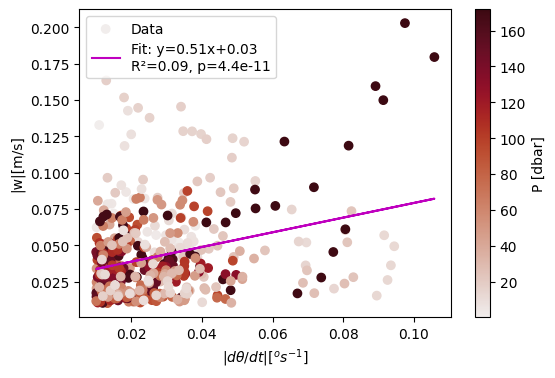

In [138]:
# Roll Rate v. Vertical Velocity
fig, ax = plt.subplots(1,1, figsize=(6, 4))
idx = (np.abs(data['roll_rate'])>0.01)  &  (np.abs(GM.w)>0.01) & ((data['dive_nr'] == dive) | (data['dive_nr'] == dive+1)) 

from scipy.stats import linregress
#x_data = data['roll_rate'][idx]
y_data = np.abs(GM.w[idx])
x_data = np.abs(data['roll_rate'][idx])
c_data = data['pressure'][idx]*10


sct=ax.scatter(x_data, y_data, c=c_data, label='Data',cmap=cmo.amp)
cbar = fig.colorbar(sct,ax=fig.gca())
cbar.set_label('P [dbar]')


slope, intercept, r_value, p_value, std_err = linregress(x_data, y_data) # Perform linear regression
fit_line = slope * np.array(x_data) + intercept 

# Plot the linear fit
ax.plot(x_data, fit_line,label=f'Fit: y={slope:.2f}x+{intercept:.2f}\nR²={r_value**2:.2f}, p={p_value:.2g}',color='m')
ax.legend()
ax.set_xlabel(r'$|d\theta/dt|[^o s^{-1}]$')
ax.set_ylabel('|w|[m/s]')
#ax.set_xlim(0,0.1)
#ax.set_ylim(0,0.1)